# Deep learning - Final model

In [78]:
import torch as t

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
NB_PAIRS = 1000
NB_EPOCHS = 25
MINI_BATCH_SIZE = 100 # seems to be quite optimal (see lesson 5.2)
NB_RUN = 10

In [3]:
train_input,train_target,train_classes,test_input,test_target,test_classes \
= prologue.generate_pair_sets(NB_PAIRS)

train_input = Variable(train_input.float(),requires_grad=True)
test_input = Variable(test_input.float(),requires_grad=True)


## Functions

In [4]:
def compute_error_classification (input, class_target):
    # input of size Nx2x10
    # target of size Nx2
    # max error N*2 = 2N
    error = 0
   
    for k in range(input.size(0)):
        for i in range(2):
            _,n = t.max(input[k,i],0)
            if n != class_target[k,i]:
                error = error + 1
    return error

In [5]:
def compute_error_comparison (input,target):
    # input of size Nx2
    # target of size N
   
    error = 0
    for k in range(input.size(0)):
        _,n = t.max(input[k],0)
        if n != target[k]:
            error = error + 1
    return error

## Learning

In [7]:
def training(model_classification,model_comparison, lr):
    ##### TO MODIFY ##############################################################################
    #sera mieux de mettre train_input , train_classes , train target in the parameters of the function ? 
    lr_ = lr
    criterion = nn.CrossEntropyLoss()
    optimizer_cl = t.optim.Adam(model_classification.parameters(),lr=lr_)
    optimizer_co = t.optim.Adam(model_comparison.parameters(),lr=lr_)
    input = train_input
    target_cl = train_classes
    target_co = train_target
    
    for e in range(NB_EPOCHS):
        sum_loss_classification = 0
        sum_loss_comparison = 0
        model_comparison.zero_grad()
        model_classification.zero_grad()
        for b in range(0,input.size(0),MINI_BATCH_SIZE):
            sum_loss = 0
            input_co = t.empty(MINI_BATCH_SIZE,2,10)
            #model_comparison.zero_grad()
            #model_classification.zero_grad()
            for i in range(2):
                # using 100 samples to train our model (fast and accurate and enough i guess )
                output_cl = model_classification(input[b:b+MINI_BATCH_SIZE,i].view(100,1,14,14)) 
                loss_cl = criterion (output_cl,target_cl[b:b+MINI_BATCH_SIZE,i].long())
                input_co[:,i,:] = output_cl
                sum_loss = sum_loss + loss_cl
                # Update parameters after backward pass
            sum_loss_classification = sum_loss_classification + sum_loss.item()
            output_co = model_comparison(input_co)
            loss_co = criterion(output_co,target_co[b:b+MINI_BATCH_SIZE].long())
            sum_loss = sum_loss*0.8 + loss_co*0.2
            #model_comparison.zero_grad()
            #model_classification.zero_grad()
            sum_loss_comparison = sum_loss_comparison + loss_co.item()
            sum_loss.backward()
            optimizer_co.step()
            optimizer_cl.step()
        ######### \ MODIFY ############################################################################
        print("Epoch no {} : \nClassification loss = {:0.4f}\nComparison loss = {:0.4f}".format(e+1,sum_loss_classification,sum_loss_comparison))


In [8]:
def test_models(model_cl, model_co, input, classes, target, train=True):
    output_cl = t.empty(NB_PAIRS,2,10)
    for i in range(2):
        output_cl[:,i,:] = model_cl(input[:,i].view(NB_PAIRS,1,14,14)) 
      
    output_co = model_co(output_cl) #1000x2

    if (train):
        s = "training"
    else:
        s = "testing"
    err1 = compute_error_classification(output_cl,classes)/2/NB_PAIRS
    err2 = compute_error_comparison(output_co, target)/NB_PAIRS
    print('\x1b[3;37;41m'+"Error in {}: \nClassification = {:0.3f}% \nComparison = {:0.3f}%".format(
          s,err1*100
          ,err2*100)+'\x1b[0m')
    return err1, err2

## Models

#### Classification

In [68]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        #1x14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256,10)
        self.b1 = nn.BatchNorm1d(128)
        self.m = nn.Softmax()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.b1(x)
        x = F.relu(self.fc3(x))
        #batchnorm here does not change much
        #dropout neither
        x = self.fc2(x)
        x = self.m(x)
        return x

In [69]:
class Classification_leaky_relu(nn.Module):
    def __init__(self):
        super(Classification_leaky_relu, self).__init__()
        #1x14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256,10)
        self.b1 = nn.BatchNorm1d(128)
        self.m = nn.Softmax()

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.leaky_relu(self.fc1(x.view(-1, 64)))
        x = self.b1(x)
        x = F.leaky_relu(self.fc3(x))
        #batchnorm here does not change much
        #dropout neither
        x = self.fc2(x)
        x = self.m(x)
        return x

In [70]:
class Classification_sigmoid(nn.Module):
    def __init__(self):
        super(Classification_sigmoid, self).__init__()
        #1x14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256,10)
        self.b1 = nn.BatchNorm1d(128)
        self.m = nn.Softmax()

    def forward(self, x):
        x = F.sigmoid(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.sigmoid(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.sigmoid(self.fc1(x.view(-1, 64)))
        x = self.b1(x)
        x = F.sigmoid(self.fc3(x))
        #batchnorm here does not change much
        #dropout neither
        x = self.fc2(x)
        x = self.m(x)
        return x

#### Comparison - 2 layers

In [33]:
class Comparison_2(nn.Module):
    def __init__(self):
        #1x10 I guess
        super(Comparison_2,self).__init__()
        self.fc1 = nn.Linear(20,32)
        self.fc2 = nn.Linear(32,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = x.view(-1,20)
        x = F.relu(self.fc1(x))
        x = self.m(self.fc2(x))
  
        return x

In [34]:
class Comparison_2_leaky_relu(nn.Module):
    def __init__(self):
        #1x10 I guess
        super(Comparison_2_leaky_relu,self).__init__()
        self.fc1 = nn.Linear(20,32)
        self.fc2 = nn.Linear(32,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = x.view(-1,20)
        x = F.leaky_relu(self.fc1(x))
        x = self.m(self.fc2(x))
  
        return x

In [35]:
class Comparison_2_sigmoid(nn.Module):
    def __init__(self):
        #1x10 I guess
        super(Comparison_2_sigmoid,self).__init__()
        self.fc1 = nn.Linear(20,32)
        self.fc2 = nn.Linear(32,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = x.view(-1,20)
        x = F.sigmoid(self.fc1(x))
        x = self.m(self.fc2(x))
  
        return x

#### Comparison - 3 layers

In [36]:
class Comparison_3(nn.Module):
    def __init__(self):
        super(Comparison_3,self).__init__()
        self.fc1 = nn.Linear(20,40)
        self.fc2 = nn.Linear(40,80)
        self.fc3 = nn.Linear(80,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = F.relu(x.view(-1,20))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.m(self.fc3(x))
        return x

In [37]:
class Comparison_3_leaky_relu(nn.Module):
    def __init__(self):
        super(Comparison_3_leaky_relu,self).__init__()
        self.fc1 = nn.Linear(20,40)
        self.fc2 = nn.Linear(40,80)
        self.fc3 = nn.Linear(80,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = F.leaky_relu(x.view(-1,20))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.m(self.fc3(x))
        return x

In [38]:
class Comparison_3_sigmoid(nn.Module):
    def __init__(self):
        super(Comparison_3_sigmoid,self).__init__()
        self.fc1 = nn.Linear(20,40)
        self.fc2 = nn.Linear(40,80)
        self.fc3 = nn.Linear(80,2)
        self.m = nn.Softplus()
        
    def forward(self,x):
        x = F.sigmoid(x.view(-1,20))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.m(self.fc3(x))
        return x

#### Comparison - 4 layers

In [39]:
class Comparison_4(nn.Module):
    def __init__(self):
        super(Comparison_4, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(x.view(-1,20))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.m(self.fc4(x))
        return x

In [40]:
class Comparison_4_leaky_relu(nn.Module):
    def __init__(self):
        super(Comparison_4_leaky_relu, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.leaky_relu(x.view(-1,20))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.m(self.fc4(x))
        return x

In [41]:
class Comparison_4_sigmoid(nn.Module):
    def __init__(self):
        super(Comparison_4_sigmoid, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.sigmoid(x.view(-1,20))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.m(self.fc4(x))
        return x

#### Comparison - 5 layers

In [42]:
class Comparison_5(nn.Module):
    def __init__(self):
        super(Comparison_5, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(x.view(-1,20))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.m(self.fc5(x))
        return x

In [43]:
class Comparison_5_leaky_relu(nn.Module):
    def __init__(self):
        super(Comparison_5_leaky_relu, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.leaky_relu(x.view(-1,20))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = self.m(self.fc5(x))
        return x

In [44]:
class Comparison_5_sigmoid(nn.Module):
    def __init__(self):
        super(Comparison_5_sigmoid, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.sigmoid(x.view(-1,20))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.m(self.fc5(x))
        return x

#### Comparison - 6 layers

In [45]:
class Comparison_6(nn.Module):
    def __init__(self):
        super(Comparison_6, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(x.view(-1,20))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.m(self.fc6(x))
        return x

In [46]:
class Comparison_6_leaky_relu(nn.Module):
    def __init__(self):
        super(Comparison_6_leaky_relu, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.leaky_relu(x.view(-1,20))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.m(self.fc6(x))
        return x

In [47]:
class Comparison_6_sigmoid(nn.Module):
    def __init__(self):
        super(Comparison_6_sigmoid, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.sigmoid(x.view(-1,20))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        x = self.m(self.fc6(x))
        return x

#### Comparison - 10 layers

In [94]:
class Comparison_10(nn.Module):
    def __init__(self):
        super(Comparison_10, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 80)
        self.fc3 = nn.Linear(80, 160)
        self.fc4 = nn.Linear(160, 320)
        self.fc5 = nn.Linear(320, 640)
        self.fc6 = nn.Linear(640, 320)
        self.fc7 = nn.Linear(320, 160)
        self.fc8 = nn.Linear(160, 80)
        self.fc9 = nn.Linear(80, 40)
        self.fc10 = nn.Linear(40, 2)
        self.m = nn.Softplus()
        
    def forward(self, x):
        x = F.relu(x.view(-1,20))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = self.m(self.fc10(x))
        return x

#### Comparison - 20 layers

## Main

In [83]:
import warnings
warnings.filterwarnings('ignore')
import pickle

#### Grid search (based on the one previously computed in the test.ipynb)

In [71]:
# Parameters
lrs = [1e-4, 1e-3, 1e-2, 1e-1]
classification_models = [Classification(), Classification_leaky_relu(), Classification_sigmoid()]

In [72]:
train_class = t.empty(NB_RUN)
train_comp = t.empty(NB_RUN)
test_class = t.empty(NB_RUN)
test_comp = t.empty(NB_RUN)

train_errors = np.zeros((len(lrs), len(classification_models)))
test_errors = np.zeros((len(lrs), len(classification_models)))


for k in range(len(lrs)):
    for l in range(len(classification_models)):
        for i in range(NB_RUN):
            model_cl = classification_models[l]
            model_co= Comparison()
            print("RUN NO {}".format(i+1))
            training(model_cl, model_co, lrs[k])

            e1, e2 = test_models(model_cl, model_co, train_input, train_classes, train_target)
            e3, e4 = test_models(model_cl, model_co, test_input, test_classes, test_target, False)
            train_class[i] = (e1)
            train_comp[i] = (e2)
            test_class[i] = (e3)
            test_comp[i] = (e4)

        print("Final error for train batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(train_comp)*100, t.std(train_comp)*100))
        print("Final error for test batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(test_comp)*100, t.std(test_comp)*100))
        
        train_error = t.mean(train_comp) * 100
        test_error = t.mean(test_comp) * 100
        
        train_errors[k, l] = train_error
        test_errors[k, l] = test_error
    

RUN NO 1
Epoch no 1 : 
Classification loss = 45.9561
Comparison loss = 6.9224
Epoch no 2 : 
Classification loss = 45.6728
Comparison loss = 6.9168
Epoch no 3 : 
Classification loss = 45.3634
Comparison loss = 6.9117
Epoch no 4 : 
Classification loss = 44.9660
Comparison loss = 6.9073
Epoch no 5 : 
Classification loss = 44.4771
Comparison loss = 6.9031
Epoch no 6 : 
Classification loss = 43.9487
Comparison loss = 6.8990
Epoch no 7 : 
Classification loss = 43.4091
Comparison loss = 6.8949
Epoch no 8 : 
Classification loss = 42.8936
Comparison loss = 6.8910
Epoch no 9 : 
Classification loss = 42.4207
Comparison loss = 6.8870
Epoch no 10 : 
Classification loss = 41.9286
Comparison loss = 6.8826
Epoch no 11 : 
Classification loss = 41.3959
Comparison loss = 6.8777
Epoch no 12 : 
Classification loss = 40.8463
Comparison loss = 6.8720
Epoch no 13 : 
Classification loss = 40.1979
Comparison loss = 6.8655
Epoch no 14 : 
Classification loss = 39.5186
Comparison loss = 6.8565
Epoch no 15 : 
Class

Epoch no 9 : 
Classification loss = 29.2726
Comparison loss = 6.8559
Epoch no 10 : 
Classification loss = 29.2694
Comparison loss = 6.8427
Epoch no 11 : 
Classification loss = 29.2637
Comparison loss = 6.8248
Epoch no 12 : 
Classification loss = 29.2636
Comparison loss = 6.7997
Epoch no 13 : 
Classification loss = 29.2635
Comparison loss = 6.7656
Epoch no 14 : 
Classification loss = 29.2633
Comparison loss = 6.7199
Epoch no 15 : 
Classification loss = 29.2635
Comparison loss = 6.6584
Epoch no 16 : 
Classification loss = 29.2635
Comparison loss = 6.5761
Epoch no 17 : 
Classification loss = 29.2634
Comparison loss = 6.4658
Epoch no 18 : 
Classification loss = 29.2634
Comparison loss = 6.3198
Epoch no 19 : 
Classification loss = 29.2633
Comparison loss = 6.1320
Epoch no 20 : 
Classification loss = 29.2633
Comparison loss = 5.8931
Epoch no 21 : 
Classification loss = 29.2633
Comparison loss = 5.5921
Epoch no 22 : 
Classification loss = 29.2633
Comparison loss = 5.2332
Epoch no 23 : 
Classi

Epoch no 18 : 
Classification loss = 29.2548
Comparison loss = 6.0699
Epoch no 19 : 
Classification loss = 29.2546
Comparison loss = 5.7996
Epoch no 20 : 
Classification loss = 29.2545
Comparison loss = 5.4836
Epoch no 21 : 
Classification loss = 29.2544
Comparison loss = 5.1405
Epoch no 22 : 
Classification loss = 29.2543
Comparison loss = 4.7921
Epoch no 23 : 
Classification loss = 29.2542
Comparison loss = 4.4450
Epoch no 24 : 
Classification loss = 29.2541
Comparison loss = 4.1118
Epoch no 25 : 
Classification loss = 29.2540
Comparison loss = 3.7971
Error in training: 
Classification = 0.150% 
Comparison = 8.700%
Error in testing: 
Classification = 5.600% 
Comparison = 10.800%
RUN NO 10
Epoch no 1 : 
Classification loss = 29.2539
Comparison loss = 6.9348
Epoch no 2 : 
Classification loss = 29.2552
Comparison loss = 6.9286
Epoch no 3 : 
Classification loss = 29.2587
Comparison loss = 6.9222
Epoch no 4 : 
Classification loss = 29.2552
Comparison loss = 6.9156
Epoch no 5 : 
Classifica

Epoch no 25 : 
Classification loss = 29.2417
Comparison loss = 2.9713
Error in training: 
Classification = 0.050% 
Comparison = 7.400%
Error in testing: 
Classification = 4.450% 
Comparison = 10.400%
RUN NO 4
Epoch no 1 : 
Classification loss = 29.2475
Comparison loss = 7.0373
Epoch no 2 : 
Classification loss = 29.2404
Comparison loss = 7.0272
Epoch no 3 : 
Classification loss = 29.2407
Comparison loss = 7.0176
Epoch no 4 : 
Classification loss = 29.2387
Comparison loss = 7.0075
Epoch no 5 : 
Classification loss = 29.2370
Comparison loss = 6.9966
Epoch no 6 : 
Classification loss = 29.2360
Comparison loss = 6.9854
Epoch no 7 : 
Classification loss = 29.2354
Comparison loss = 6.9740
Epoch no 8 : 
Classification loss = 29.2347
Comparison loss = 6.9609
Epoch no 9 : 
Classification loss = 29.2344
Comparison loss = 6.9453
Epoch no 10 : 
Classification loss = 29.2342
Comparison loss = 6.9273
Epoch no 11 : 
Classification loss = 29.2341
Comparison loss = 6.9057
Epoch no 12 : 
Classification 

Epoch no 6 : 
Classification loss = 29.2330
Comparison loss = 6.8639
Epoch no 7 : 
Classification loss = 29.2330
Comparison loss = 6.8559
Epoch no 8 : 
Classification loss = 29.2330
Comparison loss = 6.8448
Epoch no 9 : 
Classification loss = 29.2330
Comparison loss = 6.8293
Epoch no 10 : 
Classification loss = 29.2330
Comparison loss = 6.8059
Epoch no 11 : 
Classification loss = 29.2329
Comparison loss = 6.7740
Epoch no 12 : 
Classification loss = 29.2330
Comparison loss = 6.7293
Epoch no 13 : 
Classification loss = 29.2437
Comparison loss = 6.6701
Epoch no 14 : 
Classification loss = 29.2548
Comparison loss = 6.5930
Epoch no 15 : 
Classification loss = 29.2687
Comparison loss = 6.4964
Epoch no 16 : 
Classification loss = 29.3387
Comparison loss = 6.3760
Epoch no 17 : 
Classification loss = 29.2793
Comparison loss = 6.2139
Epoch no 18 : 
Classification loss = 29.3257
Comparison loss = 6.0240
Epoch no 19 : 
Classification loss = 29.2650
Comparison loss = 5.7800
Epoch no 20 : 
Classific

Epoch no 13 : 
Classification loss = 38.4733
Comparison loss = 6.8422
Epoch no 14 : 
Classification loss = 38.3964
Comparison loss = 6.8187
Epoch no 15 : 
Classification loss = 38.3089
Comparison loss = 6.7907
Epoch no 16 : 
Classification loss = 38.2068
Comparison loss = 6.7565
Epoch no 17 : 
Classification loss = 38.1176
Comparison loss = 6.7158
Epoch no 18 : 
Classification loss = 38.0182
Comparison loss = 6.6504
Epoch no 19 : 
Classification loss = 37.8926
Comparison loss = 6.5820
Epoch no 20 : 
Classification loss = 37.7776
Comparison loss = 6.4897
Epoch no 21 : 
Classification loss = 37.6455
Comparison loss = 6.3472
Epoch no 22 : 
Classification loss = 37.4406
Comparison loss = 6.2433
Epoch no 23 : 
Classification loss = 37.2544
Comparison loss = 6.0812
Epoch no 24 : 
Classification loss = 37.0832
Comparison loss = 5.8835
Epoch no 25 : 
Classification loss = 36.8423
Comparison loss = 5.7075
Error in training: 
Classification = 29.200% 
Comparison = 23.500%
Error in testing: 
Clas

Epoch no 21 : 
Classification loss = 29.3010
Comparison loss = 5.9476
Epoch no 22 : 
Classification loss = 29.2945
Comparison loss = 5.6676
Epoch no 23 : 
Classification loss = 29.2909
Comparison loss = 5.3492
Epoch no 24 : 
Classification loss = 29.2884
Comparison loss = 5.0064
Epoch no 25 : 
Classification loss = 29.2867
Comparison loss = 4.6520
Error in training: 
Classification = 0.150% 
Comparison = 17.300%
Error in testing: 
Classification = 8.450% 
Comparison = 20.400%
RUN NO 7
Epoch no 1 : 
Classification loss = 29.2886
Comparison loss = 6.8941
Epoch no 2 : 
Classification loss = 29.2833
Comparison loss = 6.8900
Epoch no 3 : 
Classification loss = 29.2817
Comparison loss = 6.8861
Epoch no 4 : 
Classification loss = 29.2798
Comparison loss = 6.8825
Epoch no 5 : 
Classification loss = 29.2765
Comparison loss = 6.8779
Epoch no 6 : 
Classification loss = 29.2737
Comparison loss = 6.8727
Epoch no 7 : 
Classification loss = 29.2708
Comparison loss = 6.8665
Epoch no 8 : 
Classificatio

Epoch no 1 : 
Classification loss = 29.5261
Comparison loss = 6.8793
Epoch no 2 : 
Classification loss = 30.4347
Comparison loss = 6.8103
Epoch no 3 : 
Classification loss = 31.3206
Comparison loss = 6.5526
Epoch no 4 : 
Classification loss = 31.1975
Comparison loss = 5.6290
Epoch no 5 : 
Classification loss = 30.4462
Comparison loss = 4.5012
Epoch no 6 : 
Classification loss = 30.2143
Comparison loss = 3.2523
Epoch no 7 : 
Classification loss = 29.9729
Comparison loss = 3.8023
Epoch no 8 : 
Classification loss = 29.6929
Comparison loss = 2.6440
Epoch no 9 : 
Classification loss = 29.5537
Comparison loss = 7.5293
Epoch no 10 : 
Classification loss = 29.5215
Comparison loss = 1.6952
Epoch no 11 : 
Classification loss = 29.4466
Comparison loss = 3.0403
Epoch no 12 : 
Classification loss = 29.4349
Comparison loss = 1.5785
Epoch no 13 : 
Classification loss = 29.3790
Comparison loss = 1.1659
Epoch no 14 : 
Classification loss = 29.3657
Comparison loss = 0.8103
Epoch no 15 : 
Classification

Epoch no 10 : 
Classification loss = 29.4212
Comparison loss = 2.8545
Epoch no 11 : 
Classification loss = 29.3202
Comparison loss = 2.5512
Epoch no 12 : 
Classification loss = 29.3936
Comparison loss = 1.9104
Epoch no 13 : 
Classification loss = 29.4012
Comparison loss = 1.3449
Epoch no 14 : 
Classification loss = 29.5400
Comparison loss = 0.9980
Epoch no 15 : 
Classification loss = 29.7011
Comparison loss = 1.3110
Epoch no 16 : 
Classification loss = 29.8873
Comparison loss = 1.9357
Epoch no 17 : 
Classification loss = 30.0687
Comparison loss = 1.7025
Epoch no 18 : 
Classification loss = 29.9413
Comparison loss = 1.2979
Epoch no 19 : 
Classification loss = 29.8427
Comparison loss = 1.1854
Epoch no 20 : 
Classification loss = 29.5583
Comparison loss = 0.7656
Epoch no 21 : 
Classification loss = 29.5672
Comparison loss = 0.5301
Epoch no 22 : 
Classification loss = 29.4405
Comparison loss = 0.3129
Epoch no 23 : 
Classification loss = 29.3938
Comparison loss = 0.2282
Epoch no 24 : 
Class

Epoch no 19 : 
Classification loss = 29.2530
Comparison loss = 0.1347
Epoch no 20 : 
Classification loss = 29.2530
Comparison loss = 0.1257
Epoch no 21 : 
Classification loss = 29.2530
Comparison loss = 0.1191
Epoch no 22 : 
Classification loss = 29.2530
Comparison loss = 0.1128
Epoch no 23 : 
Classification loss = 29.2530
Comparison loss = 0.1078
Epoch no 24 : 
Classification loss = 29.2530
Comparison loss = 0.1036
Epoch no 25 : 
Classification loss = 29.2530
Comparison loss = 0.0995
Error in training: 
Classification = 0.200% 
Comparison = 0.100%
Error in testing: 
Classification = 4.000% 
Comparison = 2.800%
RUN NO 10
Epoch no 1 : 
Classification loss = 29.2530
Comparison loss = 6.9309
Epoch no 2 : 
Classification loss = 29.2578
Comparison loss = 6.8295
Epoch no 3 : 
Classification loss = 29.3497
Comparison loss = 6.4748
Epoch no 4 : 
Classification loss = 29.2534
Comparison loss = 5.3813
Epoch no 5 : 
Classification loss = 29.2633
Comparison loss = 3.7385
Epoch no 6 : 
Classificati

Error in training: 
Classification = 0.150% 
Comparison = 0.100%
Error in testing: 
Classification = 4.700% 
Comparison = 3.500%
RUN NO 4
Epoch no 1 : 
Classification loss = 29.2739
Comparison loss = 6.8974
Epoch no 2 : 
Classification loss = 29.3024
Comparison loss = 6.8600
Epoch no 3 : 
Classification loss = 29.3446
Comparison loss = 6.7006
Epoch no 4 : 
Classification loss = 29.3053
Comparison loss = 6.0169
Epoch no 5 : 
Classification loss = 29.3557
Comparison loss = 4.5383
Epoch no 6 : 
Classification loss = 29.3749
Comparison loss = 3.6837
Epoch no 7 : 
Classification loss = 29.3899
Comparison loss = 2.8471
Epoch no 8 : 
Classification loss = 29.3415
Comparison loss = 5.4007
Epoch no 9 : 
Classification loss = 29.3442
Comparison loss = 3.3327
Epoch no 10 : 
Classification loss = 29.5749
Comparison loss = 2.1606
Epoch no 11 : 
Classification loss = 29.3428
Comparison loss = 1.4909
Epoch no 12 : 
Classification loss = 29.4521
Comparison loss = 1.0213
Epoch no 13 : 
Classification l

Epoch no 7 : 
Classification loss = 29.4747
Comparison loss = 2.7960
Epoch no 8 : 
Classification loss = 29.4041
Comparison loss = 1.4424
Epoch no 9 : 
Classification loss = 29.4155
Comparison loss = 1.2674
Epoch no 10 : 
Classification loss = 29.4225
Comparison loss = 0.4303
Epoch no 11 : 
Classification loss = 29.3728
Comparison loss = 0.4567
Epoch no 12 : 
Classification loss = 29.3930
Comparison loss = 1.4464
Epoch no 13 : 
Classification loss = 29.4117
Comparison loss = 2.7551
Epoch no 14 : 
Classification loss = 29.3776
Comparison loss = 0.4481
Epoch no 15 : 
Classification loss = 29.3631
Comparison loss = 0.9032
Epoch no 16 : 
Classification loss = 29.3639
Comparison loss = 0.3828
Epoch no 17 : 
Classification loss = 29.3631
Comparison loss = 0.1797
Epoch no 18 : 
Classification loss = 29.3630
Comparison loss = 0.1139
Epoch no 19 : 
Classification loss = 29.3630
Comparison loss = 0.0903
Epoch no 20 : 
Classification loss = 29.3630
Comparison loss = 0.0795
Epoch no 21 : 
Classifi

Epoch no 14 : 
Classification loss = 29.9476
Comparison loss = 1.1462
Epoch no 15 : 
Classification loss = 30.0375
Comparison loss = 0.9145
Epoch no 16 : 
Classification loss = 29.9940
Comparison loss = 1.0915
Epoch no 17 : 
Classification loss = 29.9791
Comparison loss = 0.9600
Epoch no 18 : 
Classification loss = 30.0642
Comparison loss = 1.0276
Epoch no 19 : 
Classification loss = 30.1367
Comparison loss = 1.1525
Epoch no 20 : 
Classification loss = 30.5636
Comparison loss = 1.3266
Epoch no 21 : 
Classification loss = 30.0539
Comparison loss = 0.9174
Epoch no 22 : 
Classification loss = 30.1905
Comparison loss = 0.8364
Epoch no 23 : 
Classification loss = 30.0061
Comparison loss = 0.7122
Epoch no 24 : 
Classification loss = 30.0499
Comparison loss = 0.8522
Epoch no 25 : 
Classification loss = 30.1365
Comparison loss = 1.1561
Error in training: 
Classification = 3.850% 
Comparison = 2.200%
Error in testing: 
Classification = 9.350% 
Comparison = 5.500%
RUN NO 3
Epoch no 1 : 
Classifi

Epoch no 23 : 
Classification loss = 29.5342
Comparison loss = 0.3600
Epoch no 24 : 
Classification loss = 29.4074
Comparison loss = 0.1078
Epoch no 25 : 
Classification loss = 29.3677
Comparison loss = 0.0886
Error in training: 
Classification = 0.650% 
Comparison = 0.100%
Error in testing: 
Classification = 7.200% 
Comparison = 4.700%
RUN NO 7
Epoch no 1 : 
Classification loss = 29.3924
Comparison loss = 6.9087
Epoch no 2 : 
Classification loss = 29.5185
Comparison loss = 6.8283
Epoch no 3 : 
Classification loss = 29.7457
Comparison loss = 6.5368
Epoch no 4 : 
Classification loss = 29.7938
Comparison loss = 5.6312
Epoch no 5 : 
Classification loss = 29.7130
Comparison loss = 4.1727
Epoch no 6 : 
Classification loss = 29.6356
Comparison loss = 3.9090
Epoch no 7 : 
Classification loss = 29.5451
Comparison loss = 3.5390
Epoch no 8 : 
Classification loss = 29.7131
Comparison loss = 5.6537
Epoch no 9 : 
Classification loss = 29.6865
Comparison loss = 4.7565
Epoch no 10 : 
Classification l

Epoch no 3 : 
Classification loss = 34.1990
Comparison loss = 6.4104
Epoch no 4 : 
Classification loss = 33.5426
Comparison loss = 5.6020
Epoch no 5 : 
Classification loss = 35.3506
Comparison loss = 6.0662
Epoch no 6 : 
Classification loss = 35.7308
Comparison loss = 6.5449
Epoch no 7 : 
Classification loss = 36.0831
Comparison loss = 5.9084
Epoch no 8 : 
Classification loss = 34.5865
Comparison loss = 5.1534
Epoch no 9 : 
Classification loss = 36.1629
Comparison loss = 5.9101
Epoch no 10 : 
Classification loss = 34.0987
Comparison loss = 5.2651
Epoch no 11 : 
Classification loss = 33.4682
Comparison loss = 5.2500
Epoch no 12 : 
Classification loss = 34.2857
Comparison loss = 5.8663
Epoch no 13 : 
Classification loss = 34.2399
Comparison loss = 5.3495
Epoch no 14 : 
Classification loss = 33.6022
Comparison loss = 4.7269
Epoch no 15 : 
Classification loss = 33.1402
Comparison loss = 4.0056
Epoch no 16 : 
Classification loss = 33.3472
Comparison loss = 4.3360
Epoch no 17 : 
Classificati

Epoch no 11 : 
Classification loss = 37.3713
Comparison loss = 6.1931
Epoch no 12 : 
Classification loss = 37.4828
Comparison loss = 5.5450
Epoch no 13 : 
Classification loss = 37.5323
Comparison loss = 5.9105
Epoch no 14 : 
Classification loss = 37.3483
Comparison loss = 6.6708
Epoch no 15 : 
Classification loss = 36.3626
Comparison loss = 6.4771
Epoch no 16 : 
Classification loss = 34.8092
Comparison loss = 5.5069
Epoch no 17 : 
Classification loss = 33.9828
Comparison loss = 5.4743
Epoch no 18 : 
Classification loss = 33.8813
Comparison loss = 6.1820
Epoch no 19 : 
Classification loss = 33.5604
Comparison loss = 5.4217
Epoch no 20 : 
Classification loss = 34.5177
Comparison loss = 4.6038
Epoch no 21 : 
Classification loss = 36.0171
Comparison loss = 4.9785
Epoch no 22 : 
Classification loss = 36.9554
Comparison loss = 6.3818
Epoch no 23 : 
Classification loss = 35.7679
Comparison loss = 6.2633
Epoch no 24 : 
Classification loss = 36.4020
Comparison loss = 5.8962
Epoch no 25 : 
Class

Epoch no 19 : 
Classification loss = 33.4629
Comparison loss = 4.2056
Epoch no 20 : 
Classification loss = 33.8077
Comparison loss = 4.9760
Epoch no 21 : 
Classification loss = 35.5554
Comparison loss = 6.6357
Epoch no 22 : 
Classification loss = 37.3430
Comparison loss = 6.4251
Epoch no 23 : 
Classification loss = 38.1728
Comparison loss = 6.3998
Epoch no 24 : 
Classification loss = 38.1448
Comparison loss = 6.0895
Epoch no 25 : 
Classification loss = 39.1035
Comparison loss = 6.0847
Error in training: 
Classification = 52.550% 
Comparison = 29.300%
Error in testing: 
Classification = 51.650% 
Comparison = 32.700%
RUN NO 10
Epoch no 1 : 
Classification loss = 39.5408
Comparison loss = 7.0020
Epoch no 2 : 
Classification loss = 39.4811
Comparison loss = 6.9031
Epoch no 3 : 
Classification loss = 39.0628
Comparison loss = 6.8917
Epoch no 4 : 
Classification loss = 38.9148
Comparison loss = 6.8518
Epoch no 5 : 
Classification loss = 38.5524
Comparison loss = 6.2801
Epoch no 6 : 
Classifi

Error in training: 
Classification = 64.400% 
Comparison = 42.300%
Error in testing: 
Classification = 64.600% 
Comparison = 43.200%
RUN NO 4
Epoch no 1 : 
Classification loss = 42.1534
Comparison loss = 6.9558
Epoch no 2 : 
Classification loss = 41.6461
Comparison loss = 6.9301
Epoch no 3 : 
Classification loss = 41.9730
Comparison loss = 6.9035
Epoch no 4 : 
Classification loss = 42.0515
Comparison loss = 6.8851
Epoch no 5 : 
Classification loss = 41.4446
Comparison loss = 6.8031
Epoch no 6 : 
Classification loss = 41.4624
Comparison loss = 6.4649
Epoch no 7 : 
Classification loss = 41.7949
Comparison loss = 6.4804
Epoch no 8 : 
Classification loss = 41.8384
Comparison loss = 6.4346
Epoch no 9 : 
Classification loss = 41.7872
Comparison loss = 6.5362
Epoch no 10 : 
Classification loss = 41.7929
Comparison loss = 6.4447
Epoch no 11 : 
Classification loss = 41.9193
Comparison loss = 6.2437
Epoch no 12 : 
Classification loss = 42.1929
Comparison loss = 6.3036
Epoch no 13 : 
Classificati

Epoch no 7 : 
Classification loss = 41.6930
Comparison loss = 6.3490
Epoch no 8 : 
Classification loss = 41.6930
Comparison loss = 6.1188
Epoch no 9 : 
Classification loss = 41.5305
Comparison loss = 6.1906
Epoch no 10 : 
Classification loss = 41.5527
Comparison loss = 6.6978
Epoch no 11 : 
Classification loss = 42.2532
Comparison loss = 6.5431
Epoch no 12 : 
Classification loss = 42.0531
Comparison loss = 6.3955
Epoch no 13 : 
Classification loss = 41.4730
Comparison loss = 5.9488
Epoch no 14 : 
Classification loss = 41.4230
Comparison loss = 5.8336
Epoch no 15 : 
Classification loss = 41.4430
Comparison loss = 5.9840
Epoch no 16 : 
Classification loss = 41.4627
Comparison loss = 6.0503
Epoch no 17 : 
Classification loss = 41.3945
Comparison loss = 5.7797
Epoch no 18 : 
Classification loss = 41.8329
Comparison loss = 6.3780
Epoch no 19 : 
Classification loss = 42.3529
Comparison loss = 6.5200
Epoch no 20 : 
Classification loss = 42.4930
Comparison loss = 6.5107
Epoch no 21 : 
Classifi

Epoch no 14 : 
Classification loss = 47.2630
Comparison loss = 6.8815
Epoch no 15 : 
Classification loss = 47.2630
Comparison loss = 6.8825
Epoch no 16 : 
Classification loss = 47.2630
Comparison loss = 6.8819
Epoch no 17 : 
Classification loss = 47.2630
Comparison loss = 6.8811
Epoch no 18 : 
Classification loss = 47.2630
Comparison loss = 6.8815
Epoch no 19 : 
Classification loss = 47.2630
Comparison loss = 6.8820
Epoch no 20 : 
Classification loss = 47.2630
Comparison loss = 6.8819
Epoch no 21 : 
Classification loss = 47.2630
Comparison loss = 6.8815
Epoch no 22 : 
Classification loss = 47.2630
Comparison loss = 6.8815
Epoch no 23 : 
Classification loss = 47.2630
Comparison loss = 6.8818
Epoch no 24 : 
Classification loss = 47.2630
Comparison loss = 6.8818
Epoch no 25 : 
Classification loss = 47.2630
Comparison loss = 6.8816
Error in training: 
Classification = 90.200% 
Comparison = 44.900%
Error in testing: 
Classification = 90.350% 
Comparison = 47.400%
RUN NO 3
Epoch no 1 : 
Clas

Epoch no 22 : 
Classification loss = 47.2630
Comparison loss = 6.8814
Epoch no 23 : 
Classification loss = 47.2630
Comparison loss = 6.8815
Epoch no 24 : 
Classification loss = 47.2630
Comparison loss = 6.8817
Epoch no 25 : 
Classification loss = 47.2630
Comparison loss = 6.8816
Error in training: 
Classification = 90.200% 
Comparison = 44.900%
Error in testing: 
Classification = 90.350% 
Comparison = 47.400%
RUN NO 7
Epoch no 1 : 
Classification loss = 47.2630
Comparison loss = 6.9110
Epoch no 2 : 
Classification loss = 47.2630
Comparison loss = 6.9086
Epoch no 3 : 
Classification loss = 47.2630
Comparison loss = 6.9064
Epoch no 4 : 
Classification loss = 47.2630
Comparison loss = 6.8834
Epoch no 5 : 
Classification loss = 47.2630
Comparison loss = 6.8808
Epoch no 6 : 
Classification loss = 47.2630
Comparison loss = 6.8877
Epoch no 7 : 
Classification loss = 47.2630
Comparison loss = 6.8903
Epoch no 8 : 
Classification loss = 47.2630
Comparison loss = 6.8779
Epoch no 9 : 
Classificati

Epoch no 2 : 
Classification loss = 44.2818
Comparison loss = 6.9315
Epoch no 3 : 
Classification loss = 47.0130
Comparison loss = 6.9315
Epoch no 4 : 
Classification loss = 47.2730
Comparison loss = 6.9315
Epoch no 5 : 
Classification loss = 47.3630
Comparison loss = 6.9315
Epoch no 6 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 7 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 8 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 9 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 10 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 11 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 12 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 13 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 14 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 15 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 16 : 
Classificatio

Epoch no 10 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 11 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 12 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 13 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 14 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 15 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 16 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 17 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 18 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 19 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 20 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 21 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 22 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 23 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 24 : 
Class

Epoch no 18 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 19 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 20 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 21 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 22 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 23 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 24 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 25 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Error in training: 
Classification = 90.750% 
Comparison = 44.900%
Error in testing: 
Classification = 90.150% 
Comparison = 47.400%
RUN NO 10
Epoch no 1 : 
Classification loss = 47.3730
Comparison loss = 18.6658
Epoch no 2 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 3 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 4 : 
Classification loss = 47.3730
Comparison loss = 6.9315
Epoch no 5 : 
Classi

Epoch no 25 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Error in training: 
Classification = 88.300% 
Comparison = 44.900%
Error in testing: 
Classification = 90.400% 
Comparison = 47.400%
RUN NO 4
Epoch no 1 : 
Classification loss = 46.8830
Comparison loss = 15.7869
Epoch no 2 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 3 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 4 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 5 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 6 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 7 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 8 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 9 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 10 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 11 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 12 : 
Classificat

Epoch no 6 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 7 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 8 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 9 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 10 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 11 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 12 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 13 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 14 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 15 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 16 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 17 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 18 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 19 : 
Classification loss = 46.8830
Comparison loss = 6.9315
Epoch no 20 : 
Classific

Epoch no 13 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 14 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 15 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 16 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 17 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 18 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 19 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 20 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 21 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 22 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 23 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 24 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 25 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Error in training: 
Classification = 90.200% 
Comparison = 44.900%
Error in testing: 
Clas

Epoch no 21 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 22 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 23 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 24 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 25 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Error in training: 
Classification = 90.200% 
Comparison = 44.900%
Error in testing: 
Classification = 90.350% 
Comparison = 47.400%
RUN NO 7
Epoch no 1 : 
Classification loss = 47.2630
Comparison loss = 15.1246
Epoch no 2 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 3 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 4 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 5 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 6 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 7 : 
Classification loss = 47.2630
Comparison loss = 6.9315
Epoch no 8 : 
Classifica

In [82]:
test_errors

array([[14.17000008, 14.03999805, 19.3900013 ],
       [ 3.29999995,  3.56000018,  5.94999981],
       [28.40999985, 33.95000076, 47.40000534],
       [47.40000534, 47.40000534, 47.92000198]])

Text(0.5, 1.0, 'Test error [%]')

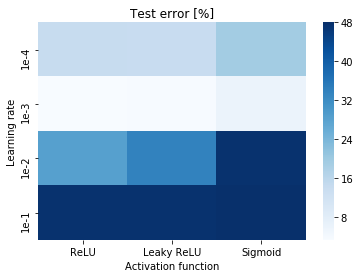

In [81]:
# Grid: model 1 (classification) optimisation
ax = sns.heatmap(test_errors, cmap = 'Blues',
                 xticklabels = ['ReLU', 'Leaky ReLU', 'Sigmoid'], yticklabels = ['1e-4', '1e-3', '1e-2', '1e-1'])
ax.set_xlabel('Activation function')
ax.set_ylabel('Learning rate')
ax.set_title('Test error [%]')
#plt.savefig('lr_vs_actfct_2.png')

In [84]:
# Save variables
with open('errors_part_1.pkl', 'wb') as f:  
    pickle.dump([train_errors, test_errors], f)

#### Grid search babe

In [53]:
# Parameters
layers = range(6)
models_2 = [[Comparison_2(), Comparison_2_leaky_relu(), Comparison_2_sigmoid()]]
models_3 = [[Comparison_3(), Comparison_3_leaky_relu(), Comparison_3_sigmoid()]]
models_4 = [[Comparison_4(), Comparison_4_leaky_relu(), Comparison_4_sigmoid()]]
models_5 = [[Comparison_5(), Comparison_5_leaky_relu(), Comparison_5_sigmoid()]]
models_6 = [[Comparison_6(), Comparison_6_leaky_relu(), Comparison_6_sigmoid()]]

all_models = np.concatenate((models_2, models_3, models_4, models_5, models_6), axis=0)

In [57]:
train_class = t.empty(NB_RUN)
train_comp = t.empty(NB_RUN)
test_class = t.empty(NB_RUN)
test_comp = t.empty(NB_RUN)

nb_rows = all_models.shape[0]
nb_cols = all_models.shape[1]

train_error_storage = np.zeros((nb_rows, nb_cols))
test_error_storage = np.zeros((nb_rows, nb_cols))

# Can add a for loop for the learning rates (only 1e-3 and 1e-2)
for k in range(nb_rows):
    for l in range(nb_cols):
        for i in range(NB_RUN):
            model_cl = Classification() #same model here
            model_co = all_models[k, l]
            print("RUN NO {}".format(i+1))
            training(model_cl, model_co, 1e-3) # lr fixed for the moment

            e1, e2 = test_models(model_cl, model_co, train_input, train_classes, train_target)
            e3, e4 = test_models(model_cl, model_co, test_input, test_classes, test_target, False)
            train_class[i] = (e1)
            train_comp[i] = (e2)
            test_class[i] = (e3)
            test_comp[i] = (e4)

        print("Final error for train batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(train_comp)*100,t.std(train_comp)*100))
        print("Final error for test batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(test_comp)*100,t.std(test_comp)*100))
        
        train_error = t.mean(train_comp) * 100
        test_error = t.mean(test_comp) * 100

        train_error_storage[k, l] = train_error
        test_error_storage[k, l] = test_error
        

RUN NO 1
Epoch no 1 : 
Classification loss = 45.6029
Comparison loss = 5.5981
Epoch no 2 : 
Classification loss = 43.8254
Comparison loss = 4.7155
Epoch no 3 : 
Classification loss = 41.6939
Comparison loss = 4.5912
Epoch no 4 : 
Classification loss = 39.2118
Comparison loss = 4.1515
Epoch no 5 : 
Classification loss = 36.9165
Comparison loss = 3.1460
Epoch no 6 : 
Classification loss = 35.2839
Comparison loss = 2.8594
Epoch no 7 : 
Classification loss = 34.1567
Comparison loss = 2.5795
Epoch no 8 : 
Classification loss = 32.8788
Comparison loss = 1.9375
Epoch no 9 : 
Classification loss = 32.2426
Comparison loss = 1.6657
Epoch no 10 : 
Classification loss = 31.7334
Comparison loss = 2.0034
Epoch no 11 : 
Classification loss = 30.8173
Comparison loss = 1.1279
Epoch no 12 : 
Classification loss = 30.6376
Comparison loss = 1.0497
Epoch no 13 : 
Classification loss = 30.3638
Comparison loss = 1.1078
Epoch no 14 : 
Classification loss = 30.1487
Comparison loss = 0.7919
Epoch no 15 : 
Class

Epoch no 10 : 
Classification loss = 31.5846
Comparison loss = 1.2716
Epoch no 11 : 
Classification loss = 31.1541
Comparison loss = 1.0041
Epoch no 12 : 
Classification loss = 30.7143
Comparison loss = 0.8096
Epoch no 13 : 
Classification loss = 30.4352
Comparison loss = 0.6671
Epoch no 14 : 
Classification loss = 30.2377
Comparison loss = 0.5744
Epoch no 15 : 
Classification loss = 30.1381
Comparison loss = 0.6078
Epoch no 16 : 
Classification loss = 29.9466
Comparison loss = 0.5079
Epoch no 17 : 
Classification loss = 29.8967
Comparison loss = 0.4771
Epoch no 18 : 
Classification loss = 29.6970
Comparison loss = 0.3705
Epoch no 19 : 
Classification loss = 29.6560
Comparison loss = 0.3187
Epoch no 20 : 
Classification loss = 29.6086
Comparison loss = 0.2786
Epoch no 21 : 
Classification loss = 29.5636
Comparison loss = 0.2666
Epoch no 22 : 
Classification loss = 29.5252
Comparison loss = 0.2548
Epoch no 23 : 
Classification loss = 29.4981
Comparison loss = 0.2258
Epoch no 24 : 
Class

Epoch no 19 : 
Classification loss = 29.5666
Comparison loss = 0.2765
Epoch no 20 : 
Classification loss = 29.5166
Comparison loss = 0.2498
Epoch no 21 : 
Classification loss = 29.4809
Comparison loss = 0.2384
Epoch no 22 : 
Classification loss = 29.4548
Comparison loss = 0.2258
Epoch no 23 : 
Classification loss = 29.4258
Comparison loss = 0.2138
Epoch no 24 : 
Classification loss = 29.4070
Comparison loss = 0.2022
Epoch no 25 : 
Classification loss = 29.4002
Comparison loss = 0.1918
Error in training: 
Classification = 0.800% 
Comparison = 0.200%
Error in testing: 
Classification = 4.600% 
Comparison = 3.300%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.5857
Comparison loss = 5.8672
Epoch no 2 : 
Classification loss = 43.5713
Comparison loss = 5.3500
Epoch no 3 : 
Classification loss = 42.5072
Comparison loss = 4.8792
Epoch no 4 : 
Classification loss = 41.6150
Comparison loss = 3.7898
Epoch no 5 : 
Classification loss = 40.2831
Comparison loss = 3.9698
Epoch no 6 : 
Classificati

Error in training: 
Classification = 0.500% 
Comparison = 0.000%
Error in testing: 
Classification = 3.950% 
Comparison = 2.500%
RUN NO 4
Epoch no 1 : 
Classification loss = 45.5862
Comparison loss = 6.3922
Epoch no 2 : 
Classification loss = 43.5108
Comparison loss = 4.5437
Epoch no 3 : 
Classification loss = 41.4873
Comparison loss = 4.4370
Epoch no 4 : 
Classification loss = 39.1506
Comparison loss = 3.7151
Epoch no 5 : 
Classification loss = 37.2376
Comparison loss = 3.7409
Epoch no 6 : 
Classification loss = 35.8387
Comparison loss = 3.5968
Epoch no 7 : 
Classification loss = 34.4590
Comparison loss = 2.2108
Epoch no 8 : 
Classification loss = 32.7613
Comparison loss = 1.8622
Epoch no 9 : 
Classification loss = 31.5413
Comparison loss = 1.5640
Epoch no 10 : 
Classification loss = 31.0908
Comparison loss = 1.3438
Epoch no 11 : 
Classification loss = 30.5920
Comparison loss = 1.2437
Epoch no 12 : 
Classification loss = 30.2012
Comparison loss = 1.0749
Epoch no 13 : 
Classification l

Epoch no 7 : 
Classification loss = 33.6473
Comparison loss = 2.1267
Epoch no 8 : 
Classification loss = 32.7694
Comparison loss = 1.8475
Epoch no 9 : 
Classification loss = 31.9471
Comparison loss = 1.6330
Epoch no 10 : 
Classification loss = 31.3624
Comparison loss = 1.0218
Epoch no 11 : 
Classification loss = 30.9665
Comparison loss = 1.2386
Epoch no 12 : 
Classification loss = 30.5388
Comparison loss = 1.0316
Epoch no 13 : 
Classification loss = 30.3871
Comparison loss = 0.7755
Epoch no 14 : 
Classification loss = 30.1117
Comparison loss = 0.5955
Epoch no 15 : 
Classification loss = 30.0311
Comparison loss = 0.7215
Epoch no 16 : 
Classification loss = 29.8216
Comparison loss = 0.4736
Epoch no 17 : 
Classification loss = 29.8469
Comparison loss = 0.5673
Epoch no 18 : 
Classification loss = 29.6692
Comparison loss = 0.3982
Epoch no 19 : 
Classification loss = 29.6713
Comparison loss = 0.4178
Epoch no 20 : 
Classification loss = 29.5939
Comparison loss = 0.4021
Epoch no 21 : 
Classifi

Epoch no 14 : 
Classification loss = 30.0509
Comparison loss = 3.0441
Epoch no 15 : 
Classification loss = 29.8250
Comparison loss = 2.9244
Epoch no 16 : 
Classification loss = 29.7732
Comparison loss = 2.7993
Epoch no 17 : 
Classification loss = 29.6950
Comparison loss = 2.6903
Epoch no 18 : 
Classification loss = 29.6370
Comparison loss = 2.5925
Epoch no 19 : 
Classification loss = 29.5724
Comparison loss = 2.4874
Epoch no 20 : 
Classification loss = 29.5061
Comparison loss = 2.3918
Epoch no 21 : 
Classification loss = 29.4491
Comparison loss = 2.2980
Epoch no 22 : 
Classification loss = 29.4253
Comparison loss = 2.2174
Epoch no 23 : 
Classification loss = 29.4095
Comparison loss = 2.1546
Epoch no 24 : 
Classification loss = 29.3880
Comparison loss = 2.0931
Epoch no 25 : 
Classification loss = 29.3743
Comparison loss = 2.0306
Error in training: 
Classification = 0.650% 
Comparison = 2.400%
Error in testing: 
Classification = 4.100% 
Comparison = 5.100%
RUN NO 3
Epoch no 1 : 
Classifi

Epoch no 23 : 
Classification loss = 29.4386
Comparison loss = 0.8475
Epoch no 24 : 
Classification loss = 29.4227
Comparison loss = 0.8410
Epoch no 25 : 
Classification loss = 29.4092
Comparison loss = 0.8375
Error in training: 
Classification = 0.800% 
Comparison = 0.700%
Error in testing: 
Classification = 4.650% 
Comparison = 3.600%
RUN NO 7
Epoch no 1 : 
Classification loss = 45.6170
Comparison loss = 5.9312
Epoch no 2 : 
Classification loss = 43.5229
Comparison loss = 4.1097
Epoch no 3 : 
Classification loss = 40.0578
Comparison loss = 3.6499
Epoch no 4 : 
Classification loss = 37.3553
Comparison loss = 3.1599
Epoch no 5 : 
Classification loss = 35.6262
Comparison loss = 2.6284
Epoch no 6 : 
Classification loss = 34.4554
Comparison loss = 2.6046
Epoch no 7 : 
Classification loss = 33.5839
Comparison loss = 2.5013
Epoch no 8 : 
Classification loss = 33.0580
Comparison loss = 2.7365
Epoch no 9 : 
Classification loss = 32.4616
Comparison loss = 1.7460
Epoch no 10 : 
Classification l

Epoch no 3 : 
Classification loss = 38.5673
Comparison loss = 6.8141
Epoch no 4 : 
Classification loss = 36.7620
Comparison loss = 6.7131
Epoch no 5 : 
Classification loss = 35.1965
Comparison loss = 6.5604
Epoch no 6 : 
Classification loss = 34.0285
Comparison loss = 6.3453
Epoch no 7 : 
Classification loss = 32.7797
Comparison loss = 5.9783
Epoch no 8 : 
Classification loss = 31.8273
Comparison loss = 5.4427
Epoch no 9 : 
Classification loss = 31.1046
Comparison loss = 4.7610
Epoch no 10 : 
Classification loss = 30.7241
Comparison loss = 4.0723
Epoch no 11 : 
Classification loss = 30.3957
Comparison loss = 3.1016
Epoch no 12 : 
Classification loss = 30.4549
Comparison loss = 2.4389
Epoch no 13 : 
Classification loss = 30.1909
Comparison loss = 1.8111
Epoch no 14 : 
Classification loss = 29.8192
Comparison loss = 1.3937
Epoch no 15 : 
Classification loss = 29.7563
Comparison loss = 1.2090
Epoch no 16 : 
Classification loss = 29.6915
Comparison loss = 0.9880
Epoch no 17 : 
Classificati

Epoch no 12 : 
Classification loss = 30.6274
Comparison loss = 0.9219
Epoch no 13 : 
Classification loss = 30.4837
Comparison loss = 1.0900
Epoch no 14 : 
Classification loss = 30.2224
Comparison loss = 0.7493
Epoch no 15 : 
Classification loss = 29.9659
Comparison loss = 0.5428
Epoch no 16 : 
Classification loss = 29.8641
Comparison loss = 0.5183
Epoch no 17 : 
Classification loss = 29.6701
Comparison loss = 0.4266
Epoch no 18 : 
Classification loss = 29.5959
Comparison loss = 0.3728
Epoch no 19 : 
Classification loss = 29.5463
Comparison loss = 0.2914
Epoch no 20 : 
Classification loss = 29.4948
Comparison loss = 0.2507
Epoch no 21 : 
Classification loss = 29.4513
Comparison loss = 0.2019
Epoch no 22 : 
Classification loss = 29.4238
Comparison loss = 0.1859
Epoch no 23 : 
Classification loss = 29.4084
Comparison loss = 0.1722
Epoch no 24 : 
Classification loss = 29.4014
Comparison loss = 0.1545
Epoch no 25 : 
Classification loss = 29.3967
Comparison loss = 0.1461
Error in training: 


Epoch no 21 : 
Classification loss = 29.3905
Comparison loss = 0.1094
Epoch no 22 : 
Classification loss = 29.3773
Comparison loss = 0.0919
Epoch no 23 : 
Classification loss = 29.3693
Comparison loss = 0.1149
Epoch no 24 : 
Classification loss = 29.3640
Comparison loss = 0.0989
Epoch no 25 : 
Classification loss = 29.3587
Comparison loss = 0.0752
Error in training: 
Classification = 0.650% 
Comparison = 0.100%
Error in testing: 
Classification = 4.600% 
Comparison = 3.100%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.6248
Comparison loss = 5.8314
Epoch no 2 : 
Classification loss = 43.7089
Comparison loss = 4.8013
Epoch no 3 : 
Classification loss = 41.3057
Comparison loss = 4.4590
Epoch no 4 : 
Classification loss = 39.2625
Comparison loss = 3.4825
Epoch no 5 : 
Classification loss = 37.1705
Comparison loss = 3.1870
Epoch no 6 : 
Classification loss = 35.5151
Comparison loss = 2.8583
Epoch no 7 : 
Classification loss = 34.2482
Comparison loss = 3.1683
Epoch no 8 : 
Classification

Epoch no 1 : 
Classification loss = 45.6152
Comparison loss = 6.3885
Epoch no 2 : 
Classification loss = 43.6203
Comparison loss = 6.8495
Epoch no 3 : 
Classification loss = 41.3565
Comparison loss = 5.4456
Epoch no 4 : 
Classification loss = 39.3892
Comparison loss = 3.9104
Epoch no 5 : 
Classification loss = 37.1878
Comparison loss = 3.4546
Epoch no 6 : 
Classification loss = 35.4394
Comparison loss = 2.4308
Epoch no 7 : 
Classification loss = 34.2731
Comparison loss = 2.3129
Epoch no 8 : 
Classification loss = 33.6293
Comparison loss = 1.8935
Epoch no 9 : 
Classification loss = 32.8188
Comparison loss = 1.1736
Epoch no 10 : 
Classification loss = 32.3863
Comparison loss = 1.2932
Epoch no 11 : 
Classification loss = 31.8907
Comparison loss = 0.9786
Epoch no 12 : 
Classification loss = 31.1641
Comparison loss = 0.8003
Epoch no 13 : 
Classification loss = 30.7060
Comparison loss = 0.8733
Epoch no 14 : 
Classification loss = 30.3658
Comparison loss = 0.6274
Epoch no 15 : 
Classification

Epoch no 10 : 
Classification loss = 30.6549
Comparison loss = 0.8307
Epoch no 11 : 
Classification loss = 30.4356
Comparison loss = 0.8943
Epoch no 12 : 
Classification loss = 30.1092
Comparison loss = 0.7271
Epoch no 13 : 
Classification loss = 30.0741
Comparison loss = 0.5767
Epoch no 14 : 
Classification loss = 29.8374
Comparison loss = 0.4080
Epoch no 15 : 
Classification loss = 29.7025
Comparison loss = 0.3560
Epoch no 16 : 
Classification loss = 29.6217
Comparison loss = 0.2694
Epoch no 17 : 
Classification loss = 29.5806
Comparison loss = 0.2434
Epoch no 18 : 
Classification loss = 29.5079
Comparison loss = 0.1645
Epoch no 19 : 
Classification loss = 29.4617
Comparison loss = 0.1953
Epoch no 20 : 
Classification loss = 29.4393
Comparison loss = 0.1580
Epoch no 21 : 
Classification loss = 29.4257
Comparison loss = 0.0820
Epoch no 22 : 
Classification loss = 29.4144
Comparison loss = 0.0750
Epoch no 23 : 
Classification loss = 29.3984
Comparison loss = 0.0709
Epoch no 24 : 
Class

Epoch no 17 : 
Classification loss = 29.4653
Comparison loss = 6.8432
Epoch no 18 : 
Classification loss = 29.4193
Comparison loss = 6.7776
Epoch no 19 : 
Classification loss = 29.3884
Comparison loss = 6.7913
Epoch no 20 : 
Classification loss = 29.3782
Comparison loss = 6.8250
Epoch no 21 : 
Classification loss = 29.3628
Comparison loss = 6.7782
Epoch no 22 : 
Classification loss = 29.3538
Comparison loss = 6.7780
Epoch no 23 : 
Classification loss = 29.3453
Comparison loss = 6.8088
Epoch no 24 : 
Classification loss = 29.3400
Comparison loss = 6.7630
Epoch no 25 : 
Classification loss = 29.3349
Comparison loss = 6.7269
Error in training: 
Classification = 0.500% 
Comparison = 44.900%
Error in testing: 
Classification = 3.650% 
Comparison = 47.400%
RUN NO 3
Epoch no 1 : 
Classification loss = 45.2164
Comparison loss = 6.8765
Epoch no 2 : 
Classification loss = 41.9348
Comparison loss = 6.9493
Epoch no 3 : 
Classification loss = 37.6654
Comparison loss = 6.8159
Epoch no 4 : 
Classific

Epoch no 25 : 
Classification loss = 29.4140
Comparison loss = 4.8547
Error in training: 
Classification = 0.850% 
Comparison = 12.900%
Error in testing: 
Classification = 4.150% 
Comparison = 14.200%
RUN NO 7
Epoch no 1 : 
Classification loss = 44.9818
Comparison loss = 7.0682
Epoch no 2 : 
Classification loss = 42.1109
Comparison loss = 6.0367
Epoch no 3 : 
Classification loss = 38.7061
Comparison loss = 5.5946
Epoch no 4 : 
Classification loss = 36.6282
Comparison loss = 5.5191
Epoch no 5 : 
Classification loss = 35.2363
Comparison loss = 5.8463
Epoch no 6 : 
Classification loss = 34.4207
Comparison loss = 5.1087
Epoch no 7 : 
Classification loss = 33.8867
Comparison loss = 5.5065
Epoch no 8 : 
Classification loss = 32.9313
Comparison loss = 4.7399
Epoch no 9 : 
Classification loss = 31.9458
Comparison loss = 4.9050
Epoch no 10 : 
Classification loss = 31.1292
Comparison loss = 5.3241
Epoch no 11 : 
Classification loss = 30.7576
Comparison loss = 4.3192
Epoch no 12 : 
Classification

Epoch no 5 : 
Classification loss = 33.0383
Comparison loss = 6.5457
Epoch no 6 : 
Classification loss = 32.3260
Comparison loss = 6.0464
Epoch no 7 : 
Classification loss = 31.7658
Comparison loss = 5.2865
Epoch no 8 : 
Classification loss = 31.1620
Comparison loss = 4.4715
Epoch no 9 : 
Classification loss = 30.4527
Comparison loss = 3.5485
Epoch no 10 : 
Classification loss = 30.4799
Comparison loss = 2.8711
Epoch no 11 : 
Classification loss = 30.0300
Comparison loss = 2.1022
Epoch no 12 : 
Classification loss = 29.8434
Comparison loss = 1.6920
Epoch no 13 : 
Classification loss = 29.8198
Comparison loss = 1.1608
Epoch no 14 : 
Classification loss = 29.8001
Comparison loss = 0.8039
Epoch no 15 : 
Classification loss = 29.6342
Comparison loss = 0.7269
Epoch no 16 : 
Classification loss = 29.5664
Comparison loss = 0.4650
Epoch no 17 : 
Classification loss = 29.5123
Comparison loss = 0.4752
Epoch no 18 : 
Classification loss = 29.4821
Comparison loss = 0.2117
Epoch no 19 : 
Classifica

Epoch no 14 : 
Classification loss = 30.2670
Comparison loss = 0.6853
Epoch no 15 : 
Classification loss = 30.0613
Comparison loss = 0.5048
Epoch no 16 : 
Classification loss = 29.9247
Comparison loss = 0.3940
Epoch no 17 : 
Classification loss = 29.7814
Comparison loss = 0.3089
Epoch no 18 : 
Classification loss = 29.6958
Comparison loss = 0.2271
Epoch no 19 : 
Classification loss = 29.6385
Comparison loss = 0.1970
Epoch no 20 : 
Classification loss = 29.5996
Comparison loss = 0.1653
Epoch no 21 : 
Classification loss = 29.5463
Comparison loss = 0.1674
Epoch no 22 : 
Classification loss = 29.5136
Comparison loss = 0.1495
Epoch no 23 : 
Classification loss = 29.4933
Comparison loss = 0.1347
Epoch no 24 : 
Classification loss = 29.4734
Comparison loss = 0.1229
Epoch no 25 : 
Classification loss = 29.4589
Comparison loss = 0.1157
Error in training: 
Classification = 1.100% 
Comparison = 0.300%
Error in testing: 
Classification = 4.950% 
Comparison = 3.000%
RUN NO 6
Epoch no 1 : 
Classifi

Epoch no 23 : 
Classification loss = 29.4101
Comparison loss = 0.1530
Epoch no 24 : 
Classification loss = 29.3880
Comparison loss = 0.1427
Epoch no 25 : 
Classification loss = 29.3779
Comparison loss = 0.1227
Error in training: 
Classification = 0.650% 
Comparison = 0.200%
Error in testing: 
Classification = 4.850% 
Comparison = 3.100%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.2020
Comparison loss = 5.5252
Epoch no 2 : 
Classification loss = 42.7548
Comparison loss = 4.4253
Epoch no 3 : 
Classification loss = 40.7518
Comparison loss = 3.6219
Epoch no 4 : 
Classification loss = 38.3456
Comparison loss = 3.1215
Epoch no 5 : 
Classification loss = 35.9609
Comparison loss = 2.5474
Epoch no 6 : 
Classification loss = 34.2094
Comparison loss = 2.2112
Epoch no 7 : 
Classification loss = 33.0064
Comparison loss = 1.6137
Epoch no 8 : 
Classification loss = 32.4877
Comparison loss = 2.0769
Epoch no 9 : 
Classification loss = 31.9533
Comparison loss = 2.0987
Epoch no 10 : 
Classification 

Epoch no 3 : 
Classification loss = 40.7419
Comparison loss = 4.3076
Epoch no 4 : 
Classification loss = 38.6638
Comparison loss = 3.3573
Epoch no 5 : 
Classification loss = 36.5479
Comparison loss = 2.6612
Epoch no 6 : 
Classification loss = 35.1461
Comparison loss = 2.4128
Epoch no 7 : 
Classification loss = 34.0414
Comparison loss = 2.2699
Epoch no 8 : 
Classification loss = 32.8086
Comparison loss = 1.9535
Epoch no 9 : 
Classification loss = 32.2711
Comparison loss = 1.4601
Epoch no 10 : 
Classification loss = 31.5885
Comparison loss = 1.1817
Epoch no 11 : 
Classification loss = 31.3798
Comparison loss = 1.3845
Epoch no 12 : 
Classification loss = 31.1737
Comparison loss = 1.2970
Epoch no 13 : 
Classification loss = 30.5866
Comparison loss = 0.7958
Epoch no 14 : 
Classification loss = 30.2781
Comparison loss = 0.6894
Epoch no 15 : 
Classification loss = 30.0061
Comparison loss = 0.5805
Epoch no 16 : 
Classification loss = 29.8824
Comparison loss = 0.5275
Epoch no 17 : 
Classificati

Epoch no 12 : 
Classification loss = 30.4389
Comparison loss = 0.7232
Epoch no 13 : 
Classification loss = 30.1302
Comparison loss = 0.4712
Epoch no 14 : 
Classification loss = 29.9322
Comparison loss = 0.5085
Epoch no 15 : 
Classification loss = 29.8498
Comparison loss = 0.3438
Epoch no 16 : 
Classification loss = 29.7483
Comparison loss = 0.2432
Epoch no 17 : 
Classification loss = 29.6235
Comparison loss = 0.2376
Epoch no 18 : 
Classification loss = 29.5486
Comparison loss = 0.2518
Epoch no 19 : 
Classification loss = 29.5019
Comparison loss = 0.2026
Epoch no 20 : 
Classification loss = 29.4604
Comparison loss = 0.2013
Epoch no 21 : 
Classification loss = 29.4595
Comparison loss = 0.1316
Epoch no 22 : 
Classification loss = 29.4267
Comparison loss = 0.1099
Epoch no 23 : 
Classification loss = 29.4061
Comparison loss = 0.0974
Epoch no 24 : 
Classification loss = 29.3911
Comparison loss = 0.0918
Epoch no 25 : 
Classification loss = 29.3795
Comparison loss = 0.0777
Error in training: 


Epoch no 19 : 
Classification loss = 29.4334
Comparison loss = 6.8443
Epoch no 20 : 
Classification loss = 29.4061
Comparison loss = 6.4932
Epoch no 21 : 
Classification loss = 29.3903
Comparison loss = 6.6228
Epoch no 22 : 
Classification loss = 29.3817
Comparison loss = 6.7296
Epoch no 23 : 
Classification loss = 29.3730
Comparison loss = 6.4118
Epoch no 24 : 
Classification loss = 29.3608
Comparison loss = 6.6109
Epoch no 25 : 
Classification loss = 29.3538
Comparison loss = 6.4244
Error in training: 
Classification = 0.550% 
Comparison = 44.900%
Error in testing: 
Classification = 4.100% 
Comparison = 47.400%
RUN NO 3
Epoch no 1 : 
Classification loss = 45.4594
Comparison loss = 6.9067
Epoch no 2 : 
Classification loss = 42.9441
Comparison loss = 7.0148
Epoch no 3 : 
Classification loss = 39.8271
Comparison loss = 6.6319
Epoch no 4 : 
Classification loss = 37.3192
Comparison loss = 6.7112
Epoch no 5 : 
Classification loss = 35.1463
Comparison loss = 6.4315
Epoch no 6 : 
Classificat

Error in testing: 
Classification = 4.150% 
Comparison = 37.900%
RUN NO 7
Epoch no 1 : 
Classification loss = 45.5079
Comparison loss = 8.0365
Epoch no 2 : 
Classification loss = 43.4864
Comparison loss = 10.2046
Epoch no 3 : 
Classification loss = 40.3795
Comparison loss = 6.1501
Epoch no 4 : 
Classification loss = 37.5375
Comparison loss = 6.4061
Epoch no 5 : 
Classification loss = 35.1549
Comparison loss = 4.2984
Epoch no 6 : 
Classification loss = 33.5409
Comparison loss = 4.8383
Epoch no 7 : 
Classification loss = 32.5482
Comparison loss = 4.0326
Epoch no 8 : 
Classification loss = 32.4973
Comparison loss = 4.4507
Epoch no 9 : 
Classification loss = 31.0812
Comparison loss = 3.5989
Epoch no 10 : 
Classification loss = 30.6468
Comparison loss = 3.8825
Epoch no 11 : 
Classification loss = 30.3317
Comparison loss = 3.8067
Epoch no 12 : 
Classification loss = 30.1710
Comparison loss = 3.4884
Epoch no 13 : 
Classification loss = 30.0434
Comparison loss = 3.6474
Epoch no 14 : 
Classific

Epoch no 7 : 
Classification loss = 33.2373
Comparison loss = 5.2809
Epoch no 8 : 
Classification loss = 32.5707
Comparison loss = 4.6366
Epoch no 9 : 
Classification loss = 32.3580
Comparison loss = 4.5758
Epoch no 10 : 
Classification loss = 32.1128
Comparison loss = 3.9857
Epoch no 11 : 
Classification loss = 31.7587
Comparison loss = 2.9293
Epoch no 12 : 
Classification loss = 31.0834
Comparison loss = 2.1146
Epoch no 13 : 
Classification loss = 30.7202
Comparison loss = 2.9038
Epoch no 14 : 
Classification loss = 30.2502
Comparison loss = 1.5834
Epoch no 15 : 
Classification loss = 30.0688
Comparison loss = 1.4869
Epoch no 16 : 
Classification loss = 29.8198
Comparison loss = 1.3209
Epoch no 17 : 
Classification loss = 29.7635
Comparison loss = 0.9430
Epoch no 18 : 
Classification loss = 29.6231
Comparison loss = 0.5397
Epoch no 19 : 
Classification loss = 29.5855
Comparison loss = 0.5239
Epoch no 20 : 
Classification loss = 29.5466
Comparison loss = 0.2919
Epoch no 21 : 
Classifi

Epoch no 16 : 
Classification loss = 29.7304
Comparison loss = 0.2009
Epoch no 17 : 
Classification loss = 29.6097
Comparison loss = 0.1563
Epoch no 18 : 
Classification loss = 29.5711
Comparison loss = 0.1211
Epoch no 19 : 
Classification loss = 29.5379
Comparison loss = 0.1553
Epoch no 20 : 
Classification loss = 29.4815
Comparison loss = 0.1096
Epoch no 21 : 
Classification loss = 29.4554
Comparison loss = 0.1022
Epoch no 22 : 
Classification loss = 29.4323
Comparison loss = 0.0799
Epoch no 23 : 
Classification loss = 29.4110
Comparison loss = 0.1352
Epoch no 24 : 
Classification loss = 29.3961
Comparison loss = 0.0568
Epoch no 25 : 
Classification loss = 29.3890
Comparison loss = 0.0548
Error in training: 
Classification = 0.700% 
Comparison = 0.100%
Error in testing: 
Classification = 4.950% 
Comparison = 3.600%
RUN NO 6
Epoch no 1 : 
Classification loss = 45.4978
Comparison loss = 5.4538
Epoch no 2 : 
Classification loss = 43.7616
Comparison loss = 6.0024
Epoch no 3 : 
Classifica

Epoch no 25 : 
Classification loss = 29.4021
Comparison loss = 0.0411
Error in training: 
Classification = 0.700% 
Comparison = 0.100%
Error in testing: 
Classification = 4.600% 
Comparison = 3.100%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.2884
Comparison loss = 6.0043
Epoch no 2 : 
Classification loss = 42.2562
Comparison loss = 4.6454
Epoch no 3 : 
Classification loss = 38.5379
Comparison loss = 3.8371
Epoch no 4 : 
Classification loss = 36.1345
Comparison loss = 2.9693
Epoch no 5 : 
Classification loss = 35.0794
Comparison loss = 2.5024
Epoch no 6 : 
Classification loss = 33.6630
Comparison loss = 1.8510
Epoch no 7 : 
Classification loss = 32.6243
Comparison loss = 1.4891
Epoch no 8 : 
Classification loss = 31.8972
Comparison loss = 1.5410
Epoch no 9 : 
Classification loss = 31.2848
Comparison loss = 1.5746
Epoch no 10 : 
Classification loss = 30.7539
Comparison loss = 0.7142
Epoch no 11 : 
Classification loss = 30.5017
Comparison loss = 0.6473
Epoch no 12 : 
Classification 

Epoch no 5 : 
Classification loss = 37.0330
Comparison loss = 3.0332
Epoch no 6 : 
Classification loss = 35.2209
Comparison loss = 2.6603
Epoch no 7 : 
Classification loss = 33.7105
Comparison loss = 2.2450
Epoch no 8 : 
Classification loss = 33.2110
Comparison loss = 2.4361
Epoch no 9 : 
Classification loss = 32.5834
Comparison loss = 1.9392
Epoch no 10 : 
Classification loss = 32.1617
Comparison loss = 1.5487
Epoch no 11 : 
Classification loss = 31.5689
Comparison loss = 1.2310
Epoch no 12 : 
Classification loss = 30.8964
Comparison loss = 1.0758
Epoch no 13 : 
Classification loss = 30.5849
Comparison loss = 0.9309
Epoch no 14 : 
Classification loss = 30.6586
Comparison loss = 1.1530
Epoch no 15 : 
Classification loss = 30.1855
Comparison loss = 0.7391
Epoch no 16 : 
Classification loss = 30.0715
Comparison loss = 0.6606
Epoch no 17 : 
Classification loss = 29.9274
Comparison loss = 0.6453
Epoch no 18 : 
Classification loss = 29.8414
Comparison loss = 0.5128
Epoch no 19 : 
Classifica

Epoch no 14 : 
Classification loss = 30.1875
Comparison loss = 0.9766
Epoch no 15 : 
Classification loss = 29.9483
Comparison loss = 0.4433
Epoch no 16 : 
Classification loss = 29.8189
Comparison loss = 0.3512
Epoch no 17 : 
Classification loss = 29.7573
Comparison loss = 0.2983
Epoch no 18 : 
Classification loss = 29.6800
Comparison loss = 0.4178
Epoch no 19 : 
Classification loss = 29.6233
Comparison loss = 0.2627
Epoch no 20 : 
Classification loss = 29.5645
Comparison loss = 0.1241
Epoch no 21 : 
Classification loss = 29.5325
Comparison loss = 0.1169
Epoch no 22 : 
Classification loss = 29.5148
Comparison loss = 0.0665
Epoch no 23 : 
Classification loss = 29.4916
Comparison loss = 0.1052
Epoch no 24 : 
Classification loss = 29.4776
Comparison loss = 0.0300
Epoch no 25 : 
Classification loss = 29.4569
Comparison loss = 0.0036
Error in training: 
Classification = 1.000% 
Comparison = 0.000%
Error in testing: 
Classification = 4.200% 
Comparison = 3.100%
RUN NO 9
Epoch no 1 : 
Classifi

Epoch no 21 : 
Classification loss = 29.4285
Comparison loss = 6.8782
Epoch no 22 : 
Classification loss = 29.4145
Comparison loss = 6.8788
Epoch no 23 : 
Classification loss = 29.4049
Comparison loss = 6.8757
Epoch no 24 : 
Classification loss = 29.3976
Comparison loss = 6.8630
Epoch no 25 : 
Classification loss = 29.3937
Comparison loss = 6.8478
Error in training: 
Classification = 0.800% 
Comparison = 44.900%
Error in testing: 
Classification = 4.100% 
Comparison = 47.400%
RUN NO 3
Epoch no 1 : 
Classification loss = 44.9800
Comparison loss = 6.8693
Epoch no 2 : 
Classification loss = 41.5022
Comparison loss = 6.8815
Epoch no 3 : 
Classification loss = 38.7120
Comparison loss = 6.8810
Epoch no 4 : 
Classification loss = 36.5890
Comparison loss = 6.8473
Epoch no 5 : 
Classification loss = 35.3419
Comparison loss = 6.8359
Epoch no 6 : 
Classification loss = 34.7686
Comparison loss = 6.8203
Epoch no 7 : 
Classification loss = 34.4670
Comparison loss = 6.8325
Epoch no 8 : 
Classificatio

Epoch no 2 : 
Classification loss = 43.2130
Comparison loss = 7.0572
Epoch no 3 : 
Classification loss = 40.1135
Comparison loss = 7.8331
Epoch no 4 : 
Classification loss = 37.3777
Comparison loss = 5.9417
Epoch no 5 : 
Classification loss = 35.9571
Comparison loss = 6.0409
Epoch no 6 : 
Classification loss = 35.0812
Comparison loss = 4.9195
Epoch no 7 : 
Classification loss = 33.9465
Comparison loss = 5.0759
Epoch no 8 : 
Classification loss = 33.2354
Comparison loss = 4.6600
Epoch no 9 : 
Classification loss = 32.3445
Comparison loss = 4.7563
Epoch no 10 : 
Classification loss = 32.1031
Comparison loss = 4.1114
Epoch no 11 : 
Classification loss = 31.6415
Comparison loss = 4.3792
Epoch no 12 : 
Classification loss = 30.9944
Comparison loss = 4.0782
Epoch no 13 : 
Classification loss = 30.4119
Comparison loss = 4.0197
Epoch no 14 : 
Classification loss = 30.2490
Comparison loss = 4.2224
Epoch no 15 : 
Classification loss = 30.0228
Comparison loss = 3.9274
Epoch no 16 : 
Classificatio

Epoch no 9 : 
Classification loss = 31.1420
Comparison loss = 4.1245
Epoch no 10 : 
Classification loss = 30.5471
Comparison loss = 4.2014
Epoch no 11 : 
Classification loss = 30.4578
Comparison loss = 3.1562
Epoch no 12 : 
Classification loss = 30.1184
Comparison loss = 2.7885
Epoch no 13 : 
Classification loss = 29.9766
Comparison loss = 1.8832
Epoch no 14 : 
Classification loss = 29.7971
Comparison loss = 0.9753
Epoch no 15 : 
Classification loss = 29.7518
Comparison loss = 0.9532
Epoch no 16 : 
Classification loss = 29.6276
Comparison loss = 0.6430
Epoch no 17 : 
Classification loss = 29.5715
Comparison loss = 0.4181
Epoch no 18 : 
Classification loss = 29.6350
Comparison loss = 0.6856
Epoch no 19 : 
Classification loss = 29.5094
Comparison loss = 0.3595
Epoch no 20 : 
Classification loss = 29.4938
Comparison loss = 0.2377
Epoch no 21 : 
Classification loss = 29.4489
Comparison loss = 0.1310
Epoch no 22 : 
Classification loss = 29.4076
Comparison loss = 0.1226
Epoch no 23 : 
Classi

Epoch no 18 : 
Classification loss = 29.5360
Comparison loss = 0.2236
Epoch no 19 : 
Classification loss = 29.5087
Comparison loss = 0.2013
Epoch no 20 : 
Classification loss = 29.4673
Comparison loss = 0.1820
Epoch no 21 : 
Classification loss = 29.4329
Comparison loss = 0.1798
Epoch no 22 : 
Classification loss = 29.4071
Comparison loss = 0.1721
Epoch no 23 : 
Classification loss = 29.3900
Comparison loss = 0.1663
Epoch no 24 : 
Classification loss = 29.3806
Comparison loss = 0.1620
Epoch no 25 : 
Classification loss = 29.3748
Comparison loss = 0.1585
Error in training: 
Classification = 0.650% 
Comparison = 0.300%
Error in testing: 
Classification = 4.100% 
Comparison = 2.800%
RUN NO 6
Epoch no 1 : 
Classification loss = 45.4422
Comparison loss = 5.8254
Epoch no 2 : 
Classification loss = 42.8826
Comparison loss = 4.6077
Epoch no 3 : 
Classification loss = 40.0024
Comparison loss = 3.7866
Epoch no 4 : 
Classification loss = 37.3722
Comparison loss = 2.6143
Epoch no 5 : 
Classificati

Error in testing: 
Classification = 4.100% 
Comparison = 3.100%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.1877
Comparison loss = 6.3648
Epoch no 2 : 
Classification loss = 42.7599
Comparison loss = 5.1774
Epoch no 3 : 
Classification loss = 40.8307
Comparison loss = 4.3702
Epoch no 4 : 
Classification loss = 38.5324
Comparison loss = 3.9493
Epoch no 5 : 
Classification loss = 35.9202
Comparison loss = 2.7901
Epoch no 6 : 
Classification loss = 34.3366
Comparison loss = 2.3155
Epoch no 7 : 
Classification loss = 32.8398
Comparison loss = 1.8442
Epoch no 8 : 
Classification loss = 31.8490
Comparison loss = 1.3265
Epoch no 9 : 
Classification loss = 31.3452
Comparison loss = 1.2028
Epoch no 10 : 
Classification loss = 31.5473
Comparison loss = 2.3734
Epoch no 11 : 
Classification loss = 30.9925
Comparison loss = 1.3454
Epoch no 12 : 
Classification loss = 30.7330
Comparison loss = 1.1436
Epoch no 13 : 
Classification loss = 30.4563
Comparison loss = 0.8367
Epoch no 14 : 
Classifica

Epoch no 7 : 
Classification loss = 34.3209
Comparison loss = 2.2632
Epoch no 8 : 
Classification loss = 33.1133
Comparison loss = 2.1432
Epoch no 9 : 
Classification loss = 32.5067
Comparison loss = 1.6959
Epoch no 10 : 
Classification loss = 31.7870
Comparison loss = 2.0903
Epoch no 11 : 
Classification loss = 30.9792
Comparison loss = 1.2113
Epoch no 12 : 
Classification loss = 30.5985
Comparison loss = 1.0074
Epoch no 13 : 
Classification loss = 30.2617
Comparison loss = 0.7648
Epoch no 14 : 
Classification loss = 30.0680
Comparison loss = 0.6106
Epoch no 15 : 
Classification loss = 30.0839
Comparison loss = 0.7076
Epoch no 16 : 
Classification loss = 29.9516
Comparison loss = 0.6266
Epoch no 17 : 
Classification loss = 29.8872
Comparison loss = 0.4752
Epoch no 18 : 
Classification loss = 29.7265
Comparison loss = 0.3553
Epoch no 19 : 
Classification loss = 29.6681
Comparison loss = 0.3061
Epoch no 20 : 
Classification loss = 29.6097
Comparison loss = 0.2776
Epoch no 21 : 
Classifi

Epoch no 16 : 
Classification loss = 29.7179
Comparison loss = 0.2656
Epoch no 17 : 
Classification loss = 29.6050
Comparison loss = 0.2685
Epoch no 18 : 
Classification loss = 29.5706
Comparison loss = 0.2247
Epoch no 19 : 
Classification loss = 29.5354
Comparison loss = 0.1929
Epoch no 20 : 
Classification loss = 29.4766
Comparison loss = 0.1323
Epoch no 21 : 
Classification loss = 29.4255
Comparison loss = 0.1002
Epoch no 22 : 
Classification loss = 29.4092
Comparison loss = 0.0908
Epoch no 23 : 
Classification loss = 29.3949
Comparison loss = 0.0867
Epoch no 24 : 
Classification loss = 29.3811
Comparison loss = 0.0643
Epoch no 25 : 
Classification loss = 29.3759
Comparison loss = 0.0421
Error in training: 
Classification = 0.650% 
Comparison = 0.200%
Error in testing: 
Classification = 3.950% 
Comparison = 2.500%
RUN NO 9
Epoch no 1 : 
Classification loss = 45.2724
Comparison loss = 5.8371
Epoch no 2 : 
Classification loss = 42.4637
Comparison loss = 4.3692
Epoch no 3 : 
Classifica

Epoch no 23 : 
Classification loss = 29.4069
Comparison loss = 6.8808
Epoch no 24 : 
Classification loss = 29.3995
Comparison loss = 6.8759
Epoch no 25 : 
Classification loss = 29.3938
Comparison loss = 6.8756
Error in training: 
Classification = 0.750% 
Comparison = 44.900%
Error in testing: 
Classification = 4.350% 
Comparison = 47.400%
RUN NO 3
Epoch no 1 : 
Classification loss = 45.3608
Comparison loss = 6.8817
Epoch no 2 : 
Classification loss = 42.6063
Comparison loss = 6.8787
Epoch no 3 : 
Classification loss = 39.7328
Comparison loss = 6.8859
Epoch no 4 : 
Classification loss = 37.6226
Comparison loss = 6.8799
Epoch no 5 : 
Classification loss = 35.6984
Comparison loss = 6.8556
Epoch no 6 : 
Classification loss = 34.0990
Comparison loss = 6.8508
Epoch no 7 : 
Classification loss = 33.1176
Comparison loss = 6.8277
Epoch no 8 : 
Classification loss = 32.5597
Comparison loss = 6.7672
Epoch no 9 : 
Classification loss = 31.9979
Comparison loss = 6.7331
Epoch no 10 : 
Classification

Epoch no 4 : 
Classification loss = 36.9779
Comparison loss = 6.7151
Epoch no 5 : 
Classification loss = 35.0835
Comparison loss = 6.0475
Epoch no 6 : 
Classification loss = 34.2991
Comparison loss = 6.3409
Epoch no 7 : 
Classification loss = 33.3382
Comparison loss = 5.2492
Epoch no 8 : 
Classification loss = 32.3264
Comparison loss = 5.5898
Epoch no 9 : 
Classification loss = 31.5875
Comparison loss = 5.3144
Epoch no 10 : 
Classification loss = 30.7147
Comparison loss = 4.9185
Epoch no 11 : 
Classification loss = 30.2988
Comparison loss = 4.9749
Epoch no 12 : 
Classification loss = 30.0201
Comparison loss = 4.7094
Epoch no 13 : 
Classification loss = 29.9934
Comparison loss = 4.3240
Epoch no 14 : 
Classification loss = 29.7179
Comparison loss = 5.8009
Epoch no 15 : 
Classification loss = 29.7113
Comparison loss = 6.0532
Epoch no 16 : 
Classification loss = 29.5297
Comparison loss = 4.7137
Epoch no 17 : 
Classification loss = 29.4981
Comparison loss = 6.7187
Epoch no 18 : 
Classificat

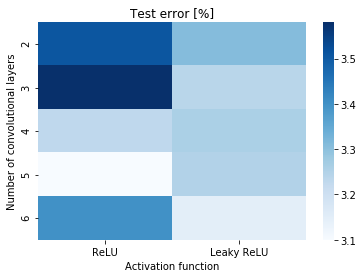

In [86]:
# Grid: nb of conv layers vs activation fct [comparison model]
ax = sns.heatmap(test_error_storage[:,0:2], cmap = 'Blues',
                 xticklabels = ['ReLU', 'Leaky ReLU'], yticklabels = ['2', '3', '4', '5', '6'])
ax.set_xlabel('Activation function')
ax.set_ylabel('Number of convolutional layers')
ax.set_title('Test error [%]')
#plt.savefig('layers_vs_actfct_test.png')

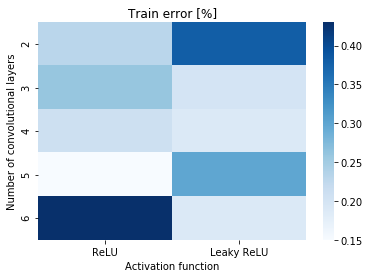

In [87]:
# Grid: nb of conv layers vs activation fct [comparison model]
ax = sns.heatmap(train_error_storage[:, 0:2], cmap = 'Blues',
                 xticklabels = ['ReLU', 'Leaky ReLU'], yticklabels = ['2', '3', '4', '5', '6'])
ax.set_xlabel('Activation function')
ax.set_ylabel('Number of convolutional layers')
ax.set_title('Train error [%]')
#plt.savefig('layers_vs_actfct_train.png')

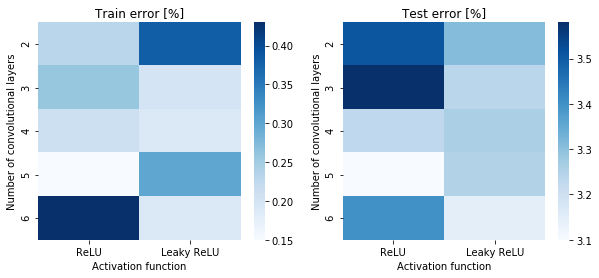

In [92]:
plt.subplots(figsize=(10,4))
plt.subplot(1,2,1)
ax = sns.heatmap(train_error_storage[:, 0:2], cmap = 'Blues',
                 xticklabels = ['ReLU', 'Leaky ReLU'], yticklabels = ['2', '3', '4', '5', '6'])
ax.set_xlabel('Activation function')
ax.set_ylabel('Number of convolutional layers')
ax.set_title('Train error [%]')
plt.subplot(1,2,2)
ax = sns.heatmap(test_error_storage[:,0:2], cmap = 'Blues',
                 xticklabels = ['ReLU', 'Leaky ReLU'], yticklabels = ['2', '3', '4', '5', '6'])
ax.set_xlabel('Activation function')
ax.set_ylabel('Number of convolutional layers')
ax.set_title('Test error [%]')
plt.savefig('layers_vs_actfct_train_and_test.png')

In [85]:
# Save variables
with open('errors_part_2.pkl', 'wb') as f:  
    pickle.dump([train_error_storage, test_error_storage], f)

In [93]:
train_error_storage

array([[ 0.23000003,  0.38      ,  2.0400002 ],
       [ 0.26000002,  0.2       , 26.23999977],
       [ 0.21000001,  0.19000001, 30.57999992],
       [ 0.15000001,  0.30000001, 30.81999969],
       [ 0.42999998,  0.19000001, 28.79000092]])

In [61]:
test_error_storage

array([[ 3.50999975,  3.3099997 ,  5.1500001 ],
       [ 3.57999992,  3.24000001, 27.36999702],
       [ 3.23000002,  3.25999999, 31.62999725],
       [ 3.0999999 ,  3.25      , 32.17000198],
       [ 3.4000001 ,  3.1500001 , 30.09000206]])

##### Second run

#### One shot

In [95]:
train_class = t.empty(NB_RUN)
train_comp = t.empty(NB_RUN)
test_class = t.empty(NB_RUN)
test_comp = t.empty(NB_RUN)

for i in range(NB_RUN):
    model_cl = Classification()
    model_co = Comparison_10()
    print("RUN NO {}".format(i+1))
    training(model_cl, model_co, 1e-3)

    e1, e2 = test_models(model_cl, model_co, train_input, train_classes, train_target)
    e3, e4 = test_models(model_cl, model_co, test_input, test_classes, test_target, False)
    train_class[i] = (e1)
    train_comp[i] = (e2)
    test_class[i] = (e3)
    test_comp[i] = (e4)
    
print("Final error for train batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(train_comp)*100,t.std(train_comp)*100))
print("Final error for test batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(test_comp)*100,t.std(test_comp)*100))

RUN NO 1
Epoch no 1 : 
Classification loss = 45.0491
Comparison loss = 6.9237
Epoch no 2 : 
Classification loss = 42.1864
Comparison loss = 6.9335
Epoch no 3 : 
Classification loss = 39.5160
Comparison loss = 6.8968
Epoch no 4 : 
Classification loss = 36.8699
Comparison loss = 6.8937
Epoch no 5 : 
Classification loss = 35.4184
Comparison loss = 6.8736
Epoch no 6 : 
Classification loss = 34.1828
Comparison loss = 6.6857
Epoch no 7 : 
Classification loss = 33.0198
Comparison loss = 6.3614
Epoch no 8 : 
Classification loss = 32.8021
Comparison loss = 5.9372
Epoch no 9 : 
Classification loss = 32.4858
Comparison loss = 6.7660
Epoch no 10 : 
Classification loss = 31.4204
Comparison loss = 5.7988
Epoch no 11 : 
Classification loss = 31.1892
Comparison loss = 5.1220
Epoch no 12 : 
Classification loss = 30.7366
Comparison loss = 5.1096
Epoch no 13 : 
Classification loss = 30.3785
Comparison loss = 4.3906
Epoch no 14 : 
Classification loss = 30.1454
Comparison loss = 3.3858
Epoch no 15 : 
Class

Epoch no 10 : 
Classification loss = 31.3518
Comparison loss = 4.8976
Epoch no 11 : 
Classification loss = 30.7940
Comparison loss = 3.9129
Epoch no 12 : 
Classification loss = 30.4885
Comparison loss = 2.8202
Epoch no 13 : 
Classification loss = 30.1767
Comparison loss = 3.4247
Epoch no 14 : 
Classification loss = 30.0942
Comparison loss = 6.7419
Epoch no 15 : 
Classification loss = 29.8967
Comparison loss = 6.1618
Epoch no 16 : 
Classification loss = 29.7558
Comparison loss = 5.2960
Epoch no 17 : 
Classification loss = 29.6374
Comparison loss = 3.6410
Epoch no 18 : 
Classification loss = 29.5868
Comparison loss = 3.6302
Epoch no 19 : 
Classification loss = 29.4882
Comparison loss = 2.6109
Epoch no 20 : 
Classification loss = 29.4645
Comparison loss = 1.5019
Epoch no 21 : 
Classification loss = 29.4370
Comparison loss = 0.5732
Epoch no 22 : 
Classification loss = 29.4171
Comparison loss = 0.6588
Epoch no 23 : 
Classification loss = 29.3900
Comparison loss = 0.2668
Epoch no 24 : 
Class

Epoch no 19 : 
Classification loss = 29.5781
Comparison loss = 1.0018
Epoch no 20 : 
Classification loss = 29.5095
Comparison loss = 1.0879
Epoch no 21 : 
Classification loss = 29.8326
Comparison loss = 0.7556
Epoch no 22 : 
Classification loss = 29.5339
Comparison loss = 0.3760
Epoch no 23 : 
Classification loss = 29.4673
Comparison loss = 0.2775
Epoch no 24 : 
Classification loss = 29.4232
Comparison loss = 0.2230
Epoch no 25 : 
Classification loss = 29.3706
Comparison loss = 0.0393
Error in training: 
Classification = 0.600% 
Comparison = 0.100%
Error in testing: 
Classification = 4.450% 
Comparison = 3.600%
RUN NO 10
Epoch no 1 : 
Classification loss = 45.1358
Comparison loss = 6.9185
Epoch no 2 : 
Classification loss = 42.0900
Comparison loss = 6.8794
Epoch no 3 : 
Classification loss = 38.5974
Comparison loss = 6.8989
Epoch no 4 : 
Classification loss = 36.2069
Comparison loss = 6.8963
Epoch no 5 : 
Classification loss = 34.9885
Comparison loss = 6.8855
Epoch no 6 : 
Classificati

In [13]:
print("Final error for train batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(train_comp)*100,t.std(train_comp)*100))
print("Final error for test batch : {:0.2f}\u00B1{:0.4f}".format(t.mean(test_comp)*100,t.std(test_comp)*100))

Final error for train batch : 0.22±0.1317
Final error for test batch : 2.92±0.4517


**Results**

Model  | Conv layers | lr  | Avg training err | Std training | Avg testing err | Std testing
---    | ---         | --- | ---              | ---          | ---             | --- 
1  | 3 | 1e-3 | 0.22 | 0.13 | **2.92** | 0.45
2  | 4 | 1e-3 | 0.29 | 0.12 | 3.30 | 0.38
3  | 4 | 1e-3 | 0.26 | 0.14 | 2.94 | 0.54 
4  | 5 | 1e-3 | 0.22 | 0.19 | 3.22 | 0.45 
5  | 6 | 1e-3 | 0.19 | 0.16 | 3.12 | 0.48




Note: 
- for model 2: 20-40-80-160-2
- for model 3: 20-40-80-40-2